Efficient net 64 batch size 50 epochs

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--timm--efficientnet_b0.ra_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\Users\Leno

Epoch 1/50, Training Loss: 0.6922, Training Accuracy: 0.5862, Validation Accuracy: 0.8667
Epoch 2/50, Training Loss: 0.2208, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 3/50, Training Loss: 0.0505, Training Accuracy: 1.0000, Validation Accuracy: 0.4667
Epoch 4/50, Training Loss: 0.0124, Training Accuracy: 1.0000, Validation Accuracy: 0.4667
Epoch 5/50, Training Loss: 0.0039, Training Accuracy: 1.0000, Validation Accuracy: 0.5333
Epoch 6/50, Training Loss: 0.0016, Training Accuracy: 1.0000, Validation Accuracy: 0.5333
Epoch 7/50, Training Loss: 0.0008, Training Accuracy: 1.0000, Validation Accuracy: 0.5333
Epoch 8/50, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Accuracy: 0.5333
Epoch 9/50, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Accuracy: 0.5333
Epoch 10/50, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Accuracy: 0.5333
Epoch 11/50, Training Loss: 0.0001, Training Accuracy: 1.0000, Validation Accuracy: 0.5333
Epoch 12

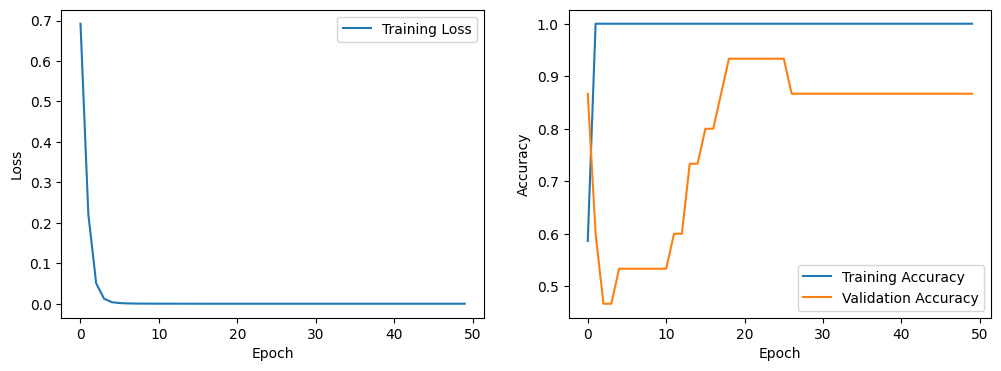

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.8667
[[6 1]
 [1 7]]
              precision    recall  f1-score   support

           0       0.86      0.86      0.86         7
           1       0.88      0.88      0.88         8

    accuracy                           0.87        15
   macro avg       0.87      0.87      0.87        15
weighted avg       0.87      0.87      0.87        15



In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import timm

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=50):
    # Image dimensions
    height, width = 224, 224  # EfficientNet expects input size (224, 224)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Load pre-trained EfficientNet model
    model = timm.create_model('efficientnet_b0', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\autograd\__init__.py:266: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/25, Training Loss: 0.7093, Training Accuracy: 0.4138, Validation Accuracy: 0.6000
Epoch 2/25, Training Loss: 0.2373, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 3/25, Training Loss: 0.0642, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 4/25, Training Loss: 0.0173, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 5/25, Training Loss: 0.0056, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 6/25, Training Loss: 0.0022, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 7/25, Training Loss: 0.0010, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 8/25, Training Loss: 0.0006, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 9/25, Training Loss: 0.0003, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 10/25, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 11/25, Training Loss: 0.0002, Training Accuracy: 1.0000, Validation Accuracy: 0.6000
Epoch 12

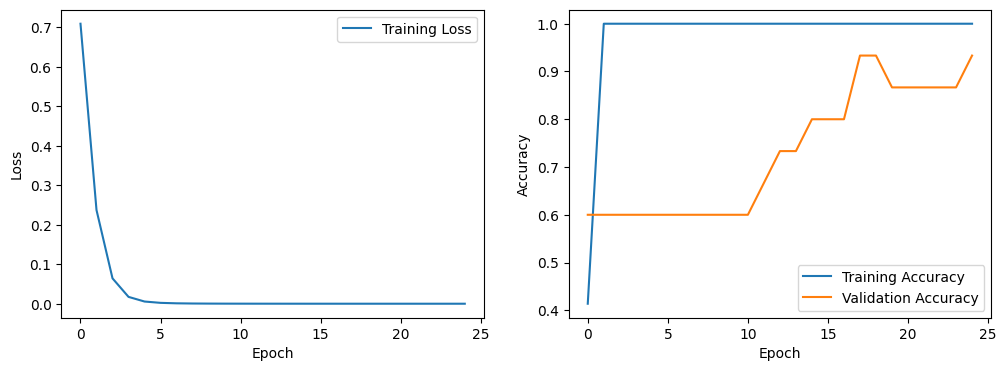

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9333
[[8 1]
 [0 6]]
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.86      1.00      0.92         6

    accuracy                           0.93        15
   macro avg       0.93      0.94      0.93        15
weighted avg       0.94      0.93      0.93        15



In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import timm

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=25):
    # Image dimensions
    height, width = 224, 224  # EfficientNet expects input size (224, 224)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Load pre-trained EfficientNet model
    model = timm.create_model('efficientnet_b0', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            predictions = torch.argmax(outputs, 1)

            y_true.extend(labels.numpy())
            y_pred.extend(predictions.numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Epoch 1/25, Training Loss: 0.3992, Training Accuracy: 0.7759, Validation Accuracy: 0.8667
Epoch 2/25, Training Loss: 0.0856, Training Accuracy: 0.9655, Validation Accuracy: 0.8667
Epoch 3/25, Training Loss: 0.0501, Training Accuracy: 0.9828, Validation Accuracy: 0.9333
Epoch 4/25, Training Loss: 0.1124, Training Accuracy: 0.9310, Validation Accuracy: 0.8667
Epoch 5/25, Training Loss: 0.0334, Training Accuracy: 1.0000, Validation Accuracy: 1.0000
Epoch 6/25, Training Loss: 0.2448, Training Accuracy: 0.9483, Validation Accuracy: 1.0000
Epoch 7/25, Training Loss: 0.0707, Training Accuracy: 0.9655, Validation Accuracy: 0.9333
Epoch 8/25, Training Loss: 0.0587, Training Accuracy: 0.9828, Validation Accuracy: 0.7333
Epoch 9/25, Training Loss: 0.0456, Training Accuracy: 0.9828, Validation Accuracy: 0.9333
Epoch 10/25, Training Loss: 0.1657, Training Accuracy: 0.9828, Validation Accuracy: 0.9333
Epoch 11/25, Training Loss: 0.0450, Training Accuracy: 0.9828, Validation Accuracy: 0.9333
Epoch 12

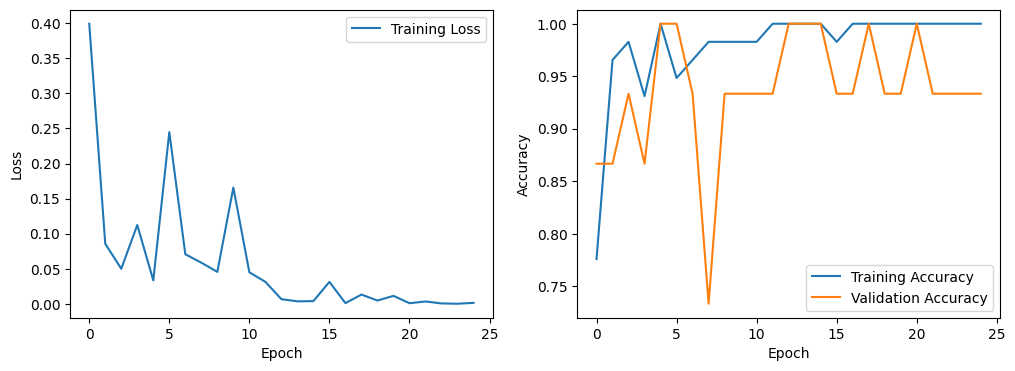

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.9333
Predicted Class Values: [1 0 1 0 0 0 1 0 0 1 0 0 1 0 0]
True Class Values: [1 0 1 0 0 1 1 0 0 1 0 0 1 0 0]
[[9 0]
 [1 5]]
              precision    recall  f1-score   support

           0       0.90      1.00      0.95         9
           1       1.00      0.83      0.91         6

    accuracy                           0.93        15
   macro avg       0.95      0.92      0.93        15
weighted avg       0.94      0.93      0.93        15

Sensitivity: 0.8333
Specificity: 1.0000
Confusion matrix, without normalization
[[9 0]
 [1 5]]


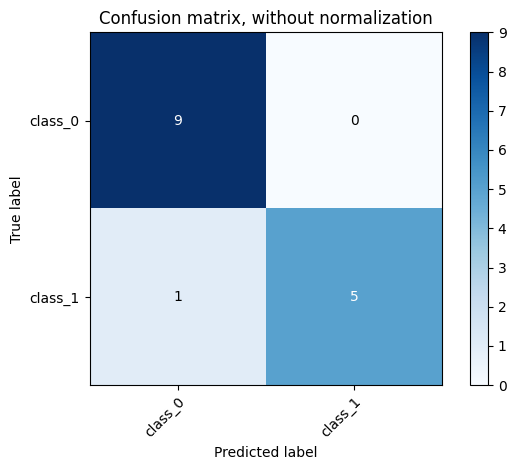

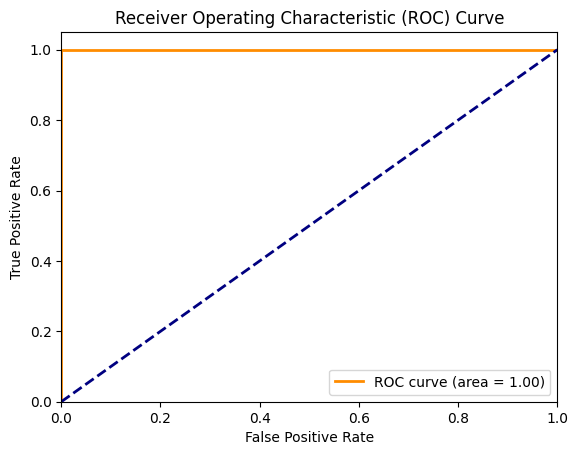

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=25):
    # Image dimensions
    height, width = 224, 224  # EfficientNet expects input size (224, 224)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # Load pre-trained EfficientNet model
    model = timm.create_model('efficientnet_b0', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['class_0', 'class_1'])

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Sakar dataset -755 datapoint

epoch 10
batchsize 32

Epoch 1/10, Training Loss: 0.6012, Training Accuracy: 0.6724, Validation Accuracy: 0.6000
Epoch 2/10, Training Loss: 0.1046, Training Accuracy: 0.9828, Validation Accuracy: 0.8000
Epoch 3/10, Training Loss: 0.0175, Training Accuracy: 1.0000, Validation Accuracy: 0.8000
Epoch 4/10, Training Loss: 0.0065, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 5/10, Training Loss: 0.0016, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 6/10, Training Loss: 0.0008, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 7/10, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 8/10, Training Loss: 0.0008, Training Accuracy: 1.0000, Validation Accuracy: 0.6667
Epoch 9/10, Training Loss: 0.0015, Training Accuracy: 1.0000, Validation Accuracy: 0.7333
Epoch 10/10, Training Loss: 0.0004, Training Accuracy: 1.0000, Validation Accuracy: 0.7333


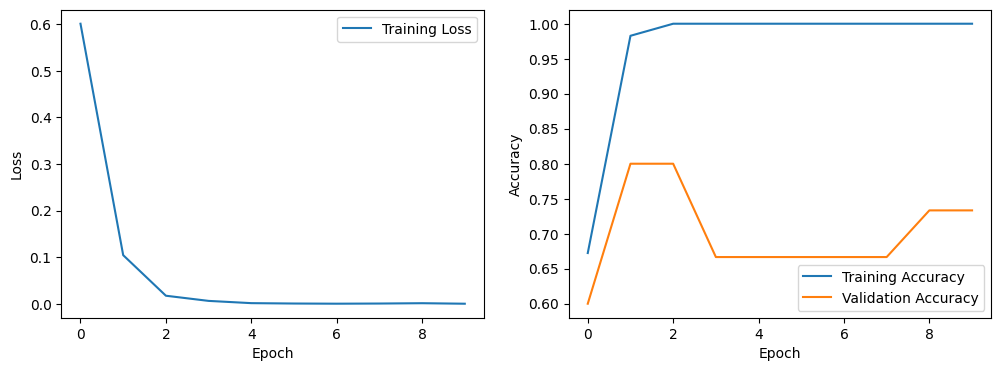

Final Training Accuracy: 1.0000
Final Validation Accuracy: 0.7333
Predicted Class Values: [0 0 0 0 1 0 0 0 1 0 0 1 0 1 0]
True Class Values: [0 1 1 0 1 0 0 1 1 0 0 1 0 1 1]
[[7 0]
 [4 4]]
              precision    recall  f1-score   support

           0       0.64      1.00      0.78         7
           1       1.00      0.50      0.67         8

    accuracy                           0.73        15
   macro avg       0.82      0.75      0.72        15
weighted avg       0.83      0.73      0.72        15

Sensitivity: 0.5000
Specificity: 1.0000
Confusion matrix, without normalization
[[7 0]
 [4 4]]


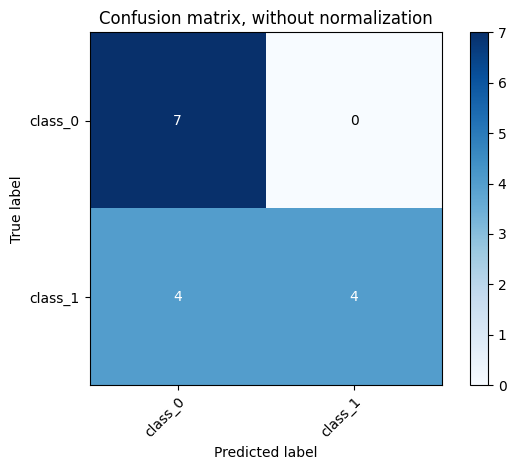

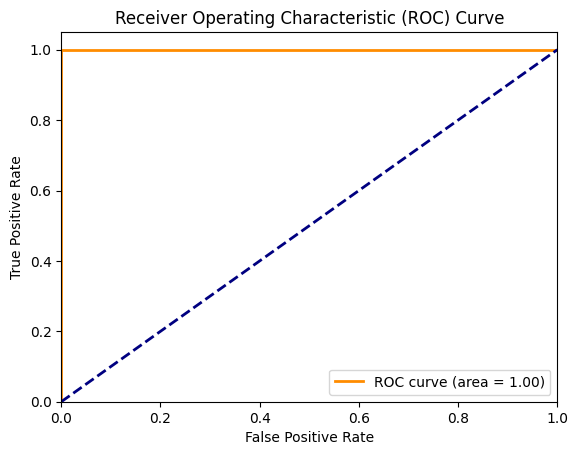

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=10):
    # Image dimensions
    height, width = 224, 224  # EfficientNet expects input size (224, 224)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained EfficientNet model
    model = timm.create_model('efficientnet_b0', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['class_0', 'class_1'])

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Spectrogram"
train_and_evaluate(data_path)


Sakar dataset -755 datapoints

batch 32
epoch 10

Epoch 1/10, Training Loss: 0.4843, Training Accuracy: 0.7500, Validation Accuracy: 0.8553
Epoch 2/10, Training Loss: 0.2461, Training Accuracy: 0.8907, Validation Accuracy: 0.8553
Epoch 3/10, Training Loss: 0.1929, Training Accuracy: 0.9089, Validation Accuracy: 0.7500
Epoch 4/10, Training Loss: 0.0827, Training Accuracy: 0.9719, Validation Accuracy: 0.8750
Epoch 5/10, Training Loss: 0.0936, Training Accuracy: 0.9735, Validation Accuracy: 0.8224
Epoch 6/10, Training Loss: 0.0561, Training Accuracy: 0.9735, Validation Accuracy: 0.8684
Epoch 7/10, Training Loss: 0.0863, Training Accuracy: 0.9685, Validation Accuracy: 0.8355
Epoch 8/10, Training Loss: 0.0538, Training Accuracy: 0.9801, Validation Accuracy: 0.8553
Epoch 9/10, Training Loss: 0.0628, Training Accuracy: 0.9768, Validation Accuracy: 0.8816
Epoch 10/10, Training Loss: 0.0389, Training Accuracy: 0.9901, Validation Accuracy: 0.9145


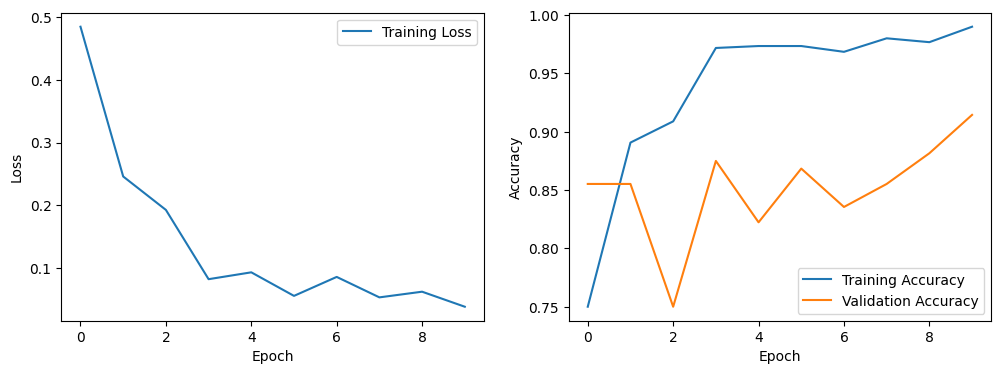

Final Training Accuracy: 0.9901
Final Validation Accuracy: 0.9145
Predicted Class Values: [1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 0 0 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 0 0 1 1]
True Class Values: [1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0
 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 0
 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 0 1 1 1]
[[ 27   7]
 [  6 112]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.81        34
           1       0.94      0.95      0.95       118

    accuracy                           0.91       152
   macro avg       0.88      0

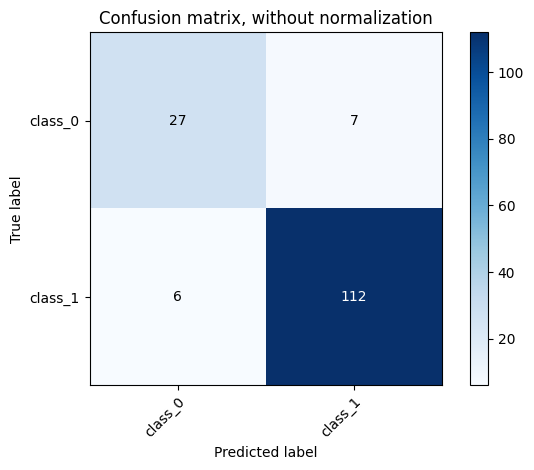

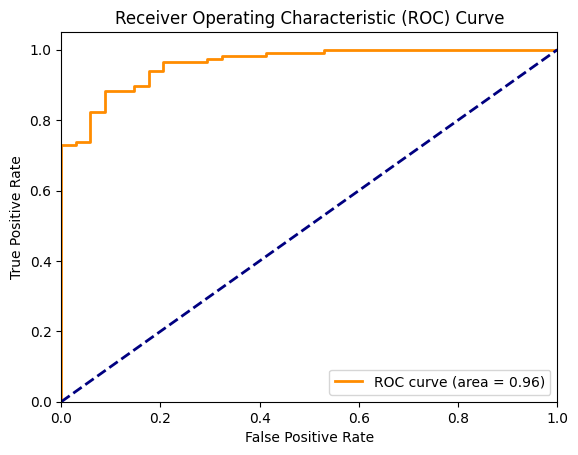

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=10):
    # Image dimensions
    height, width = 224, 224  # EfficientNet expects input size (224, 224)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained EfficientNet model
    model = timm.create_model('efficientnet_b0', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['class_0', 'class_1'])

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Sakar pd speech time series converted\Normalised\spectrogram"
train_and_evaluate(data_path)


lr = 0.0001

Epoch 1/10, Training Loss: 0.5351, Training Accuracy: 0.7881, Validation Accuracy: 0.5724
Epoch 2/10, Training Loss: 0.2924, Training Accuracy: 0.8957, Validation Accuracy: 0.7961
Epoch 3/10, Training Loss: 0.1540, Training Accuracy: 0.9520, Validation Accuracy: 0.8289
Epoch 4/10, Training Loss: 0.0563, Training Accuracy: 0.9983, Validation Accuracy: 0.8553
Epoch 5/10, Training Loss: 0.0318, Training Accuracy: 0.9967, Validation Accuracy: 0.8487
Epoch 6/10, Training Loss: 0.0202, Training Accuracy: 1.0000, Validation Accuracy: 0.8487
Epoch 7/10, Training Loss: 0.0098, Training Accuracy: 1.0000, Validation Accuracy: 0.8421
Epoch 8/10, Training Loss: 0.0061, Training Accuracy: 1.0000, Validation Accuracy: 0.8618
Epoch 9/10, Training Loss: 0.0195, Training Accuracy: 0.9934, Validation Accuracy: 0.8289
Epoch 10/10, Training Loss: 0.0315, Training Accuracy: 0.9868, Validation Accuracy: 0.7500


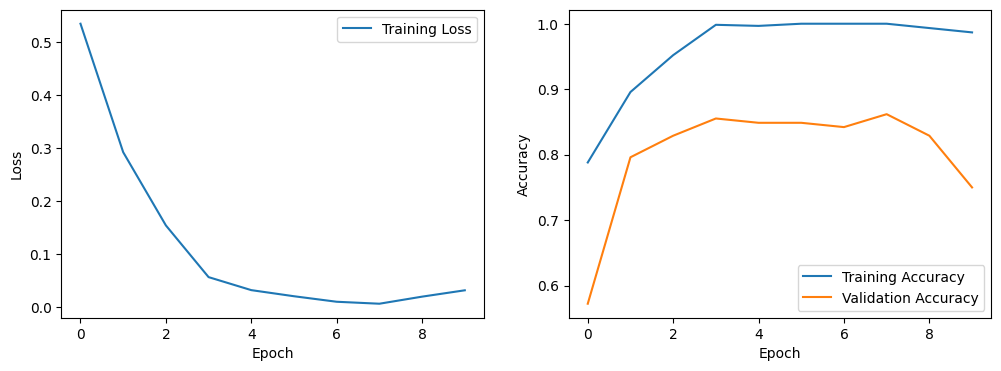

Final Training Accuracy: 0.9868
Final Validation Accuracy: 0.7500
Predicted Class Values: [1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 0 1 0 0 1 1 1 1
 1 1 1 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1
 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 1 1 1
 1 0 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 1 1 1 1 0 0 1
 1 1 0 0]
True Class Values: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1
 1 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1
 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1
 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 1
 1 1 1 1]
[[34  5]
 [33 80]]
              precision    recall  f1-score   support

           0       0.51      0.87      0.64        39
           1       0.94      0.71      0.81       113

    accuracy                           0.75       152
   macro avg       0.72      0.79 

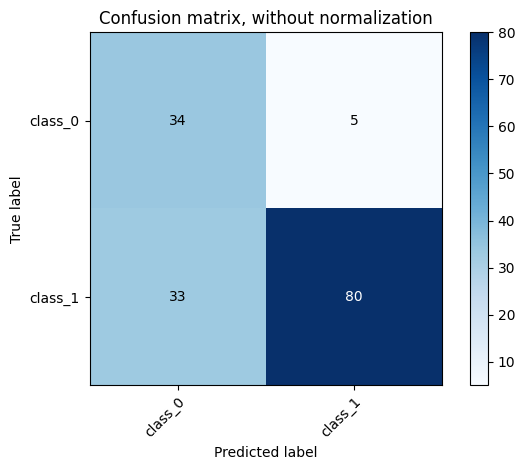

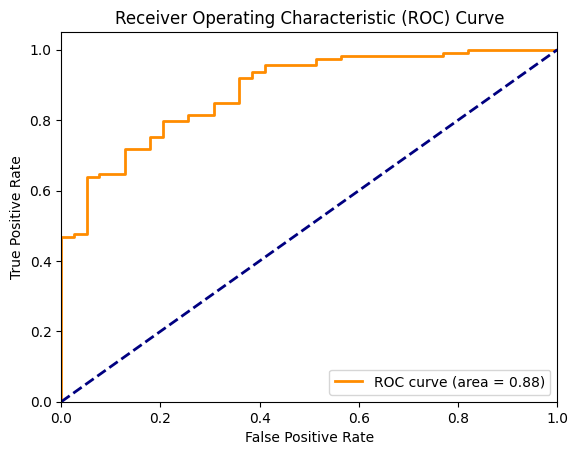

In [3]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import timm
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

def train_and_evaluate(data_path, split_ratio=0.8, num_epochs=10):
    # Image dimensions
    height, width = 224, 224  # EfficientNet expects input size (224, 224)

    # Data transformation
    transform = transforms.Compose([
        transforms.Resize((height, width)),
        transforms.ToTensor(),
    ])

    # Create dataset
    dataset = ImageFolder(root=data_path, transform=transform)

    # Split dataset into training and validation sets
    total_size = len(dataset)
    train_size = int(split_ratio * total_size)
    val_size = total_size - train_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create loaders
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Load pre-trained EfficientNet model
    model = timm.create_model('efficientnet_b0', pretrained=True)

    # Modify the last fully connected layer for binary classification
    num_classes = 2  # Adjust according to your number of classes
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)

    model.train()

    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    # Lists to store the learning curve data
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        average_train_loss = running_loss / len(train_loader)
        train_losses.append(average_train_loss)
        train_accuracy = correct_train / total_train
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        y_pred_probs = []
        y_true = []
        y_pred = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
                y_true.extend(labels.numpy())
                y_pred.extend(predicted.numpy())
                y_pred_probs.extend(torch.softmax(outputs, 1)[:, 1].tolist())  # Probability for class 1 (positive)

        val_accuracy = correct_val / total_val
        val_accuracies.append(val_accuracy)

        # Print training loss and validation accuracy
        print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Training Loss: {average_train_loss:.4f}, '
              f'Training Accuracy: {train_accuracy:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}')

    # Plot the learning curve
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Print final training and validation accuracy
    print(f'Final Training Accuracy: {train_accuracies[-1]:.4f}')
    print(f'Final Validation Accuracy: {val_accuracies[-1]:.4f}')

    # Evaluation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Print predicted class values and true class values
    print("Predicted Class Values:", y_pred)
    print("True Class Values:", y_true)

    # Print confusion matrix and classification report
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))

    # Calculate and print specificity and sensitivity
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    print(f'Sensitivity: {sensitivity:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # Plot confusion matrix
    plot_confusion_matrix(y_true, y_pred, classes=['class_0', 'class_1'])

    # Plot ROC curve and calculate AUC
    plot_roc_curve(y_true, y_pred_probs)

# Example usage
data_path = r"C:\Users\Lenovo\Downloads\PD AUDIO DATA\Sakar pd speech time series converted\Normalised\spectrogram"
train_and_evaluate(data_path)
